## Set up

In [47]:
import numpy as np
import matplotlib.pyplot as plt

## Coupled CANN

- [x] dt = 1% tau 
- [x] Gaussian White Noise: mean = 0, variance = 1
- [x] $\sqrt{dt}$ for dt
- [ ] Simultation about Langevin Sampling

### Question 2

1. How to set Laplacian Matrix?

### Questions 1:

##### 1. Poisson Variability

- How Poisson Variability is represented by Eq.11 #Questions  

##### 2. Fano Factor $F$

What is the mean and variance of the Fano Factor
Try $\sigma =a, \mu = s_m$ , due to “(C) The feedforward input is modeled as continuous approximation of Poisson spikes with Gaussian tuning over the stimulus feature.” ([Zhang et al., 2020, p. 5](zotero://select/library/items/5GZ6Z4HR)) ([pdf](zotero://open-pdf/library/items/KDU4GASG?page=5&annotation=NVNWK6G7))
- Just let $F = 1$ due to "Poisson"What is the mean and variance of the Fano Factor 

- Try $\sigma =a, \mu = s_m$ , due to “(C) The feedforward input is modeled as continuous approximation of Poisson spikes with Gaussian tuning over the stimulus feature.” ([Zhang et al., 2020, p. 5](zotero://select/library/items/5GZ6Z4HR)) ([pdf](zotero://open-pdf/library/items/KDU4GASG?page=5&annotation=NVNWK6G7))
Just let $F = 1$ due to "Poisson"

Just let $F = 0.5$, this is not important

##### 3. $\textbf{I}_m^\textrm{f}$, Feedforward input

1. “Based on the Gaussian tuning and Poisson variability (Eq. 9), the likelihood of sm given an observed Ifm is also a Gaussian distribution (Fig. 2E), i.e., $p(\textbf{I}^\textrm{f}_m|s_m) = p(x_m|s_m) = \mathcal{N} (x_xm|s_m, \Lambda^{-1}_m )$ ” (Zhang et al., 2020, p. 4)  


2. What's the relationship between $\textbf{I}_m^\textrm{f}$ and $x_m$ ?


“the probability of observing a particular value of $\textbf{I}_m^\textrm{f}$ given $s_m$ ” ([Zhang et al., 2020, p. 4](zotero://select/library/items/5GZ6Z4HR)) ([pdf](zotero://open-pdf/library/items/KDU4GASG?page=4&annotation=PQ8LA5RS))  
	- Eq. 9  
$$
	  \textbf{I}_m^\textrm{f} \mid s_m \sim  \prod_{j = 1}^N \textrm{Poisson}[\lambda_{m, j}(s_m)], \lambda_{m, j}(s_m) = \textrm{I}_m^\textrm{f} \exp[-(\theta_j - s_m)/2 a^2]
	  $$ 
3. What does the symbol $\sim$ mean? the distribution of?
    
##### 4. Internal Poisson-like Variability  

- How Poisson Variability is represented by Eq.11 
    
##### 5. Langevin Sampling  

- $s^{\textbf{r}}_{mt}$ in Eq.12 and $s^{\textbf{r}}_m$ in Eq.14, are they same ? 

- “DU = diag(U1, U2, · · · , UM ) and Df = diag(If1, If2, · · · , If M ) are diagonal matrices, denoting the peak value of the mean synaptic input, and the mean feedforward input in each network respectively” ([Zhang et al., 2020, p. 6](zotero://select/library/items/5GZ6Z4HR)) ([pdf](zotero://open-pdf/library/items/KDU4GASG?page=6&annotation=JBE6P2DA))  
	- Only can get either peak value or mean value at a instant time


### Implementation

In [189]:
class CoupledCANN:
    theta_min = -180
    theta_max = 180
    stim_width = 360  # width of stimuli. 2pi
    M = int(2)  # consider only two-coupled CANNs for now

    def __init__(self, tau=1, N=180, a=40, k=5e-4, F=0.5, R=[51, 52], Ip=[1, 1]):
        """ Constructor
        :param tau: time constant, defined as 1 ms
        :param N: number of neurons in each network
        :param k: global inhibition strength
        :param F: Fano Factor, set to 0.5
        :param R: peak firing rates of each network
        :param Ip: peak input rates of each network
        """
        self.tau, self.N, self.a, self.k, self.F, self.R, self.Ip = tau, N, a, k, F, R, Ip
        self.s, self.s1, self.s2 = np.zeros(shape=(2, 1)), [], [] # 2 stimuli s_1 and s_2
        self.d_theta, self.rau = self.stim_width / self.N, self.N/self.stim_width
        # init firing rate (r), synaptic input (u), feedforward input (If)
        self.r = self.u = self.If = np.zeros(shape=(self.M, self.N))
        # set preferred stimuli for neurons in each network
        self.theta = np.tile(((np.arange(0, self.N, 1) + 0.5) * self.d_theta + self.theta_min), (self.M, 1))
        self.wrc = 2*np.sqrt(2)*np.power(2*np.pi, 0.25) * np.sqrt(self.k*self.a*self.rau)
        self.Uc = self.wrc / (2*np.sqrt(np.pi)*self.k*self.a)
        self.Ip=[self.Uc, self.Uc]
        self.wf = self.set_wf()  # set wf: the feedforward connection weight, assumed same in different networks
        self.wr = self.set_wr()  # set wr: the recurrent connection weight
        self.Wf = self.set_Wf()  # set feedforward connection kernel Wf
        self.Wr = self.set_Wr()  # set recurrent connection kernel Wr
        self.set_input()

    def g_theta(self, theta):
        """Gaussian function for calculating connection matrices
        :param theta: stimuli values
        """
        return np.exp(-theta ** 2 / 2 * self.a ** 2) / (np.sqrt(2 * np.pi)*self.a)

    def set_wf(self):
        """Set feedforward connection weight wf
        Refer to Eq.17
        """
        return (2 / np.sqrt(3)) ** 3 * self.F

    def set_wr(self):
        """Set recurrent connection matrix
        Refer to Eq.17
        Refer to Supplement Material
        """
        # wr = np.array([[1, -1], [-1, 1]], dtype=float)  # the L matrix
        # for m in range(self.M):
        #     for n in range(self.M):
        #         up = self.a * self.wf * wr[m][n]
        #         down = (np.sqrt(2 * np.pi) * self.rau * self.R[n])
        #         wr[m][n] = up / down
        return np.array([[self.wrc, 0.5*self.wrc], [0.5*self.wrc, self.wrc]])

    def set_Wf(self):
        """Set feedforward connection kernel
        Refer to Eq.7
        :return:
        """
        return self.wf * self.g_theta(self.theta)

    def set_Wr(self):
        """Set recurrent connection kernel
        Refer to Eq.7
        :return Wr (3D array, indexing by Wr[m1][m2][theta])
        """
        Wr = np.zeros(shape=(self.M, self.M, self.N))
        for m in range(self.M):
            for n in range(self.M):
                p = self.wr[m][n] * self.g_theta(self.theta[m])
                # print(f'm:{m}, n:{n}, wr[m][n]:{self.wr[m][n]}, G-theta:{self.g_theta(self.theta[m])}, P: {p}')
                Wr[m][n] = p
        return Wr

    def set_input(self, i=[0, 0]):
        """Set input to I^f_m,
        :param i: peak stimuli (heading direction etc.)
        """
        if len(i) != self.M:
            raise ValueError("Network number not matched")
        for m in range(self.M):
            self.If[m] = self.Ip[m] * np.exp((self.theta[m] - i[m]) ** 2 / (2 * self.a ** 2))

    def calc_r(self):
        """
        Calculate firing rates r by synaptic input u, refer to Eq.8
        :return:
        """
        for m in range(self.M):
            self.r[m] = self.u[m] ** 2 / (1 + self.k * self.rau * np.sum(self.u[m] ** 2 * self.d_theta))

    def calc_dudt(self, dt):
        """
        Calculate the synaptic input u, refer to Eq.6
        square dt for the stochastic part
        :param dt: let dt = 1% tau
        :return:
        """
        dudt = np.zeros(shape=(self.M, self.N))
        for m in range(self.M):
            r, f, = np.zeros(shape=(self.N,)), np.convolve(self.Wf[m], self.If[m], "same")
            # print(f'Wr[m]:{self.Wf[m].shape}, If[m]:{self.If[m].shape} f:{f.shape}')
            noise = np.sqrt(self.tau * self.F * self.u[m]) * np.random.default_rng().normal(0, 1, 1)[0]
            for n in range(self.M):
                r += np.convolve(self.Wr[m][n], self.r[n], "same")
            dudt[m] = -self.u[m] + self.rau * (r + f)
            dudt[m] = dudt[m] * dt + noise * np.sqrt(dt)
        return dudt / self.tau

    def calc_ds(self):
        """Langevin Sampling, refer to Eq.12
        """
        x = np.sum(np.multiply(self.r, self.theta), axis=1)
        y = np.sum(self.r, axis=1)
        s = x / y
        return s

    def step(self, dt):
        self.calc_r()
        self.u += self.calc_dudt(dt)
        self.s = self.calc_ds()
        self.s1.append(self.s[0])
        self.s2.append(self.s[1])
        return


net = CoupledCANN()


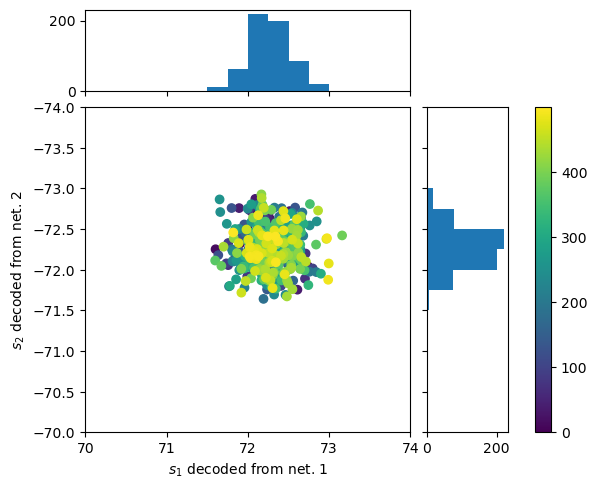

In [195]:
tau = 1
dt = tau/100
T = range(int(6 * tau // dt))
net = CoupledCANN(tau=tau)

for t in T:
    net.set_input(i=[-2, 2])
    net.step(dt)
    # print(net.s)



def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    # ax.scatter(x, y, c=range(len((net.s1))), vmin=0, vmax=len(net.s1))

    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')

x=net.s1[100:]
y=net.s2[100:]
fig = plt.figure(constrained_layout=True)
ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
ax.set(aspect=1)
ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)
scatter_hist(net.s1, net.s2, ax, ax_histx, ax_histy)
plt.xlabel('$s_1$ decoded from net. 1')
plt.ylabel('$s_2$ decoded from net. 2')
plt.scatter(x=x, y=y, c=range(len(x)), vmin=0, vmax=len(x))
plt.colorbar()
plt.xlim(70, 74)
plt.ylim(-70, -74)
plt.show()